In [1]:
import os
import pandas as pd
import numpy as np
import re
import sqlite3
import string
from datetime import datetime as dt
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
import gensim

import time

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
con = sqlite3.connect('/content/drive/MyDrive/pheno_tweets/Twitter/labelled_data.db')
cur = con.cursor()
res = cur.execute("SELECT * FROM labelled_data;").fetchall()
temp_res = cur.execute("SELECT * FROM labelled_data;").fetchall()

In [5]:
# Problem with the utf-8 characters: original input file recognize these slashes as a string, not a special character
# whereas if you initialize a var = str('/xe9'), it will still recognize this slash as a special character for utf-8
# so this will be different from the utf-8 code we extract from database.

# asdf = cur.execute("SELECT text FROM Tweets_Data_Unique where keyword = 'flower' AND status_id = 'b''1262997263690813441''';").fetchall()
# asdf[0] = list(asdf[0])
# asdf[0][0] = asdf[0][0][2:]
# aaaa = str(asdf[0][0])
# aaaa = str(aaaa[66:90])
# llll = "\xed\x8c\x90\xeb\xa7\xa4"
# print(aaaa == llll)
# print(aaaa.encode('utf-8').decode('utf-8', 'ignore'))
# print(llll.encode('utf-8').decode('utf-8', 'ignore'))

# My solution is just to remove them all, since there is no reason to recognize emojis in NLP


def removeUrl(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)
    
def removeEmoji(text):
#     emojis = re.findall(r'\\x\S+',text)
#     return emojis
#     emojis = re.compile(r'\S+(\\n+)|\\x\S+(#+)|\\x\S+')
    emojis = re.compile(r'\S?\\x(\\n+)|\\x\S+(#+)|\\x\S+')
    return emojis.sub(r'',text)

def removePunc(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

def removeSpecialChar(text):
    nxtln = re.compile(r'\S?\\n')
    ans = nxtln.sub(r' ',text)
    rt = re.compile(r'RT\S?')
    newAns = rt.sub(r'', ans)
    at = re.compile(r'@\S+')
    return at.sub(r'', newAns)
    
# -----------------------------Test Section-----------------------------
# Data preprocessing
# asdf = cur.execute("SELECT text FROM Tweets_Data where keyword = 'flower' AND status_id = 'b''1262997405428969472''';").fetchall()
# asdf[0] = list(asdf[0])
# asdf[0][0] = asdf[0][0][2:]
# print(asdf[0][0])
# asdf[0][0] = removeUrl(asdf[0][0])
# print("after removing url: " + asdf[0][0])
# asdf[0][0] = removeEmoji(asdf[0][0])
# print("after removing emoji: " + asdf[0][0])
# asdf[0][0] = removeSpecialChar(asdf[0][0])
# print("after removing specialchar: " + asdf[0][0])
# asdf[0][0] = removePunc(asdf[0][0])
# print("after removing punctuations: " + asdf[0][0])
# asdf[0][0] = asdf[0][0].lower()


# # Stemming and Lemmatization
# stop_words = set(stopwords.words('english'))
# lem = nltk.stem.WordNetLemmatizer()
# stem = nltk.stem.PorterStemmer()

# print("len of string before stop words removal: {0}".format(len(asdf[0][0])))
# temp_list = nltk.word_tokenize(asdf[0][0])
# # not sure if I need to use stemming, not sure things like 'going' -> 'go' would matter
# temp_list = [stem.stem(lem.lemmatize(word)) for word in temp_list if word not in stop_words]
# asdf[0][0] = ' '.join(temp_list)
# print("len of string after stop words removal {0}".format(len(asdf[0][0])))
# print(asdf[0][0])





# -----------------------------Production Section-----------------------------
# https://realpython.com/python-encodings-guide/
# this website tells how to decode these utf-8 symbols
# b" means it is in byte format, so it will need to be in bytes, but we only have strings
# print(b"\xf0\x9f\x8f\x88\xf0\x9f\x92\xaa\xf0\x9f\x8f\xbe".decode("utf-8"))

# remove all unnecessary stuff + Lemmatization
stop_words = set(stopwords.words('english'))
lem = nltk.stem.WordNetLemmatizer()
stem = nltk.stem.PorterStemmer()
for i in range(len(res)):
    res[i] = list(res[i])
    res[i][2] = res[i][2][2:]
    res[i][2] = removeUrl(res[i][2])
    res[i][2] = removeEmoji(res[i][2])
    res[i][2] = removeSpecialChar(res[i][2])
    res[i][2] = removePunc(res[i][2])
    res[i][2] = res[i][2].lower()
    tmp_list = nltk.word_tokenize(res[i][2])
    tmp_list = [lem.lemmatize(word) for word in tmp_list if word not in stop_words]
    res[i][2] = ' '.join(tmp_list)
    res[i] = res[i][2]

# con.commit()
# con.close()


In [ ]:
print(temp_res[0])

(1576, "b'1263178736729567232'", "b'RT @nikkigrimes9: The first bloom of my newest addition! It took its sweet time because it was less excited about blooming than I was. http\\xe2\\x80\\xa6'", 'bloom', 1, 1)


In [16]:
tfidf_transform[1].todense()

matrix([[0., 0., 0., ..., 0., 0., 0.]])

In [6]:
# Or we could use TF IDF, whichever the result is better (TFIDF or CountVectorizer)
print("Sklearn: TFIDF.  First 25 entries:")
tfidf_vec = TfidfVectorizer(use_idf=True)
# this tfidf_transform returns for each word of each tweet, their index and associated score
tfidf_transform = tfidf_vec.fit_transform(res)

# the tfidf_transform index below is used to select which tweet to see the TF-IDF score for each word
df = pd.DataFrame(tfidf_transform[0].T.todense(), index=tfidf_vec.get_feature_names_out(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print (df.head(25))


# reference: https://towardsdatascience.com/tf-idf-explained-and-python-sklearn-implementation-b020c5e83275

Sklearn: TFIDF.  First 25 entries:
                     TF-IDF
newest             0.399562
addition           0.363424
blooming           0.326633
http               0.319072
le                 0.308215
excited            0.307505
sweet              0.296693
took               0.294702
first              0.237081
time               0.207076
bloom              0.190411
paulowina          0.000000
patton             0.000000
patted             0.000000
pausing            0.000000
paused             0.000000
pause              0.000000
patter             0.000000
pattern            0.000000
patterned          0.000000
patterning         0.000000
paus               0.000000
patternwildflower  0.000000
patti              0.000000
patting            0.000000


In [ ]:
# Feed TFIDF data into LDA model
print("Sklearn: TFIDF + LDA")

# Uncomment this link for default LDA Setting
# lda_tfidf = LatentDirichletAllocation(n_components=50, max_iter=10, 
#                                       learning_method='online')

# Uncomment this linke for fine tuned LDA Setting
lda_tfidf = LatentDirichletAllocation(n_components=50, max_iter=10, doc_topic_prior=0.8, learning_decay=0.8, 
                                      learning_offset=4, topic_word_prior=0.8, learning_method='online')


lda_tfidf = LatentDirichletAllocation(n_components=50)
afterLda_tfidf = lda_tfidf.fit_transform(tfidf_transform)

# Output of afterLda: total 71374 lists (each tweet has a list), each list has 50 entries
# each entries are weights so this looks at each tweet, and see how related they are to the 50 entries?
print(afterLda_tfidf)


Sklearn: TFIDF + LDA
[[0.00470547 0.00470547 0.00470547 ... 0.00470547 0.00470547 0.00470547]
 [0.00521547 0.00521547 0.00521547 ... 0.00521547 0.00521547 0.00521547]
 [0.0058203  0.0058203  0.0058203  ... 0.0058203  0.0058203  0.71480526]
 ...
 [0.00507878 0.00507878 0.00507878 ... 0.00507878 0.00507878 0.00507878]
 [0.00480525 0.00480525 0.00480525 ... 0.00480525 0.00480525 0.00480525]
 [0.00590079 0.00590079 0.00590079 ... 0.00590079 0.00590079 0.00590079]]


In [ ]:
print("******************Sklearn method result")

# get all features (all of the words basically)
allFeatures = tfidf_vec.get_feature_names_out()
# print(allFeatures)


# topicDic: topics --> combinations of features sort by weights
topicDic = {}
for idx, ele in enumerate(lda_tfidf.components_):
    sorted_indices = ele.argsort();
    feature_indices = sorted_indices[:len(ele)-11:-1]
    feature_names = [allFeatures[i] for i in feature_indices]
    topicDic[idx] = feature_names
print("All topics are shown below: ")
for ele in topicDic:
  print(topicDic[ele])


    
# Go through each tweets, get their highest related topic
topicsForEach = []
for ele in range(len(afterLda_tfidf)):
    maxNum = 0.00001
    maxIdx = 0
    for i in range(len(afterLda_tfidf[ele])):
        if afterLda_tfidf[ele][i] > maxNum:
            maxNum = afterLda_tfidf[ele][i]
            maxIdx = i;
    topicsForEach.append(maxIdx)



    
# For visualization: 
# Print 4 of them just to save space
for i in range(4):
    print('Tweet: {}, Topic: {}'.format(i,topicDic[topicsForEach[i]]))
    
# Print actual tweet content to verify
for i in range(4):
    print("Tweet {}: ,{}".format(i, res[i]))

    
# reference: https://towardsdatascience.com/introduction-to-topic-modeling-using-scikit-learn-4c3f3290f5b9






******************Sklearn method result
All topics are shown below: 
['oil', 'tree', 'tea', 'plant', 'climbing', 'flower', 'marijuana', 'si', 'leaf', 'horse']
['tree', 'plant', 'bud', 'vegetable', 'flower', 'yea', 'drink', 'choose', 'goodnight', 'one']
['tree', 'flower', 'ima', 'plant', 'tryna', 'watered', 'one', 'bud', 'plum', 'mess']
['flower', 'sewer', 'problem', 'tree', 'plant', 'reason', 'planting', 'growing', 'daisy', 'line']
['flower', 'tree', 'jimin', 'power', 'observatory', 'bloom', 'hair', 'slide', 'hum', 'youve']
['plant', 'based', 'tree', 'without', 'life', 'buy', 'diet', 'art', 'flower', 'featured']
['2020', 'plan', 'army', 'plant', 'flower', 'cottagecore', 'young', 'cloud', 'need', 'people']
['mask', 'trump', 'wear', 'ford', 'okay', 'plant', 'flower', 'visit', 'beautiful', 'president']
['sorry', 'bud', 'tree', 'mango', 'im', 'turning', 'plant', 'apparently', 'climate', 'new']
['fight', 'flower', 'big', 'ring', 'plant', 'netflix', 'beaded', 'tree', 'day', 'watching']
['ya'

In [ ]:
print(temp_res[0])
answer_list = [temp_res[i][4] for i in range(len(temp_res))]
total_ones = answer_list.count(1)
print(len(answer_list))
print(total_ones)
print(len(topicsForEach))

(1576, "b'1263178736729567232'", "b'RT @nikkigrimes9: The first bloom of my newest addition! It took its sweet time because it was less excited about blooming than I was. http\\xe2\\x80\\xa6'", 'bloom', 1, 1)
124000
1242
124000


In [ ]:

print("With fine tuning, sklearn with 50 topics (strictly phenology) will have the following results:")

list_of_false_neg = []

# this part has to be manually changed every time the model is generated (topics are different every time we create/train our model)
# According to the result of previou cell, has to manually define which topic is related to phenology, which might be related
phenology_related_topics = [3,10 ,15,32,38,43,44]
maybe_phenology_related = [0,22,34, 35,40,41, 49]

true_pos = 0
true_neg = 0
false_pos = 0
false_neg = 0
for i in range(len(topicsForEach)):
  if topicsForEach[i] in phenology_related_topics or topicsForEach[i] in maybe_phenology_related:
  # if topicsForEach[i] in phenology_related_topics:
    if answer_list[i]== 1:
      true_pos +=1
    else:
      false_pos +=1
  else:
    if answer_list[i] == 1:
      temp_list = [res[i], topicDic[topicsForEach[i]]]
      list_of_false_neg.append(temp_list)
      false_neg +=1
    else:
      true_neg +=1
print("total length: ",len(topicsForEach))
print("true_pos: ", true_pos)
print("false_pos: ", false_pos)
print("false_neg: ", false_neg)
print("true_neg: ", true_neg)
print("total number of labelled positives: ", total_ones)
print("correctness: ", (true_pos+true_neg)/len(topicsForEach))


With fine tuning, sklearn with 50 topics (strictly phenology) will have the following results:
total length:  124000
true_pos:  482
false_pos:  34043
false_neg:  760
true_neg:  88715
total number of labelled positives:  1242
correctness:  0.7193306451612903


In [ ]:
print("False negative overviews: ")
cnt = 0
for ele in list_of_false_neg:
  print("Tweet: ", ele[0])
  print("Wrongly categorized: ", ele[1])
  print("Correct Label: ", ele[3] )
  cnt+=1;
  if cnt== 100:
    break;

False negative overviews: 
Tweet:  first bloom newest addition took sweet time le excited blooming http
Correct label: 
Wrongly categorized:  ['tree', 'lemon', 'flower', 'shop', 'plant', 'like', 'climb', 'life', 'branch', 'etsy']
Tweet:  fuchsia finally one open bloom today lot bloom baby ready thriving
Correct label: 
Wrongly categorized:  ['okay', 'luck', 'bud', 'flower', 'tree', 'good', 'plant', 'ticket', 'leaf', 'ugh']
Tweet:  beautiful flower bloom garden like tomato pepper
Correct label: 
Wrongly categorized:  ['flower', 'fallin', 'woojin', 'prettiest', 'stream', 'plant', 'fav', 'power', 'tree', 'kite']
Tweet:  white crabapple blossom say hello back
Correct label: 
Wrongly categorized:  ['plant', 'ford', 'positive', 'day', 'chicago', 'test', 'worker', 'covid19', 'employee', 'leave']
Tweet:  blooming tree boston neighborhood happy forward day late spring springforward spring20
Correct label: 
Wrongly categorized:  ['based', 'plant', 'diet', 'plantbased', 'tree', 'vegan', 'flower',

In [ ]:
# For testing purposes

con = sqlite3.connect('/content/drive/MyDrive/pheno_tweets/Twitter/test.db')

test_sql = pd.read_sql_query("SELECT count(*) FROM Tweets_Data;", con)
# print("correct num: ", 165208)
test_sql = pd.read_sql_query("SELECT count(*) FROM Tweets_Data_Unique;", con)
print(test_sql)
# print("correct num: ", 71374)


con.close()

   count(*)
0    603784


In [ ]:
import matplotlib
import numpy as np
from matplotlib import pyplot as plt

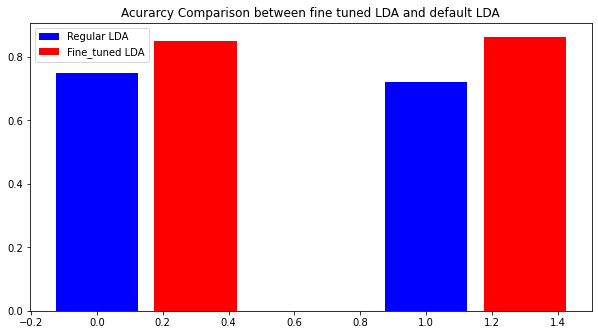

In [ ]:
data=[[0.75, 0.7193], [0.8496, 0.8633]]
numOfArea = np.arange(2)
new_fig = plt.figure()
ax = new_fig.add_axes([0.2,0.1,1.3,1])
ax.bar(numOfArea, data[0], color='b', width=0.25)
ax.bar(numOfArea+0.3, data[1], color='r', width=0.25)
ax.set_title("Acurarcy Comparison between fine tuned LDA and default LDA")
ax.legend(labels=["Regular LDA", "Fine_tuned LDA"])
plt.show()



In [ ]:
print("Gensim: generating bow corpus...")

# To use gensim, each tweet needs to be in a word list format
for i in range(len(res)):
    res[i] = res[i].split()


# Here transforms the tweets into Dictionary (wordID-to-word formatting)
dictionary = gensim.corpora.Dictionary(res)
# then for each Dictionary entry, convert document into the (BoW) format = list of (token_id, token_count) tuples
# they just represent words in token_id format
# e.g. (1, 1), (8, 2)
bow_corpus = [dictionary.doc2bow(doc) for doc in res]
print("Done")

Gensim: generating bow corpus...
Done


In [ ]:
print("Gensim: BoW + LDA")


# Bag of Words + LDA with gensim
lda_gensim = gensim.models.LdaMulticore(bow_corpus, num_topics=50, id2word=dictionary, passes=2, workers=3)
print("All topics generated: ")
for ele in lda_gensim.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(ele[0], ele[1]))



Gensim: BoW + LDA
All topics generated: 
Topic: 0 
Words: 0.048*"yes" + 0.036*"tree" + 0.031*"money" + 0.024*"fruit" + 0.022*"plant" + 0.019*"leave" + 0.016*"day" + 0.015*"add" + 0.015*"story" + 0.014*"thousand"
Topic: 1 
Words: 0.028*"game" + 0.025*"though" + 0.017*"leaf" + 0.014*"wont" + 0.013*"behind" + 0.013*"fig" + 0.011*"plant" + 0.011*"tree" + 0.010*"simple" + 0.009*"da"
Topic: 2 
Words: 0.059*"tree" + 0.025*"dollar" + 0.019*"lemon" + 0.015*"safe" + 0.014*"maple" + 0.013*"loved" + 0.010*"form" + 0.009*"truly" + 0.009*"warm" + 0.009*"memory"
Topic: 3 
Words: 0.043*"bud" + 0.041*"light" + 0.031*"tree" + 0.023*"hey" + 0.015*"side" + 0.012*"sleep" + 0.012*"road" + 0.011*"strong" + 0.011*"men" + 0.009*"spot"
Topic: 4 
Words: 0.034*"baby" + 0.025*"like" + 0.023*"tree" + 0.021*"girl" + 0.019*"woman" + 0.016*"bud" + 0.015*"point" + 0.015*"fan" + 0.015*"damn" + 0.014*"weed"
Topic: 5 
Words: 0.039*"plant" + 0.027*"tree" + 0.021*"planted" + 0.015*"idea" + 0.015*"moon" + 0.012*"welcome" + 0

In [ ]:
##################
# TFIDF + LDA with gensim
print("Gensim: TFIDF + LDA")
tfidf_gensim = gensim.models.TfidfModel(bow_corpus)
tfidf_corpus = tfidf_gensim[bow_corpus]
lda_tfidf_gensim = gensim.models.LdaMulticore(tfidf_corpus, num_topics=20, id2word=dictionary, passes=2, workers=5)
print("All topics generated: ")
for ele in lda_tfidf_gensim.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(ele[0], ele[1]))


Gensim: TFIDF + LDA
All topics generated: 
Topic: 0 
Words: 0.009*"bud" + 0.007*"plant" + 0.006*"sorry" + 0.006*"hope" + 0.005*"tree" + 0.005*"flower" + 0.004*"like" + 0.003*"rose" + 0.003*"bloom" + 0.003*"care"
Topic: 1 
Words: 0.012*"done" + 0.006*"plant" + 0.005*"bud" + 0.005*"leaf" + 0.005*"tree" + 0.004*"flower" + 0.003*"best" + 0.003*"seed" + 0.003*"like" + 0.003*"whatever"
Topic: 2 
Words: 0.009*"girl" + 0.008*"flower" + 0.008*"tree" + 0.007*"soft" + 0.006*"ikon" + 0.006*"plant" + 0.005*"yes" + 0.004*"mom" + 0.004*"bloom" + 0.004*"plastic"
Topic: 3 
Words: 0.010*"chemical" + 0.007*"plant" + 0.007*"dow" + 0.006*"midland" + 0.005*"dam" + 0.004*"michigan" + 0.004*"bud" + 0.004*"tree" + 0.003*"flower" + 0.003*"flood"
Topic: 4 
Words: 0.007*"flower" + 0.005*"bud" + 0.005*"tree" + 0.004*"plant" + 0.004*"luck" + 0.004*"without" + 0.004*"woojin" + 0.004*"ya" + 0.004*"jungkook" + 0.003*"child"
Topic: 5 
Words: 0.010*"flower" + 0.007*"boy" + 0.005*"plant" + 0.005*"tree" + 0.004*"show" + 0

In [ ]:
print("******************Gensim method result")


# Some notices on methods: 
# lda_tfidf_gensim.get_topics() = vectors with length 48523, total 20(# of topics) vectors

# lda_tfidf_gensim.get_topic_terms(n) = for topic # n, returns the 10 top representations in 
# pair format: (word ID, its probability)

# lda_tfidf_gensim.get_document_topics(bow_corpus[i]) = for tweet # i, returns 
# a tuple containing (top topics, its %)

# bow_corpus is what we use to go through tweets


allTopicsNames = [ ele[1] for ele in lda_tfidf_gensim.print_topics(-1)]


# Here we only get first 4, just to save some print space
for i in range(4):
    topTopicNum = lda_tfidf_gensim.get_document_topics(bow_corpus[i])[0][0]
    topTopicName = allTopicsNames[topTopicNum];
    print("Tweet {}, Topic: {}".format(i, topTopicName))

    
for i in range(4):
    print("Tweet {}: {}".format(i, res[i]))


******************Gensim method result
Tweet 0, Topic: 0.010*"apple" + 0.010*"fall" + 0.009*"far" + 0.008*"plant" + 0.008*"chemical" + 0.008*"dow" + 0.007*"tree" + 0.005*"positive" + 0.005*"midland" + 0.005*"stay"
Tweet 1, Topic: 0.026*"bud" + 0.010*"good" + 0.010*"flower" + 0.010*"love" + 0.009*"happy" + 0.007*"like" + 0.007*"birthday" + 0.006*"tree" + 0.006*"hope" + 0.006*"look"
Tweet 2, Topic: 0.011*"done" + 0.007*"thank" + 0.007*"tree" + 0.006*"plant" + 0.006*"bud" + 0.005*"based" + 0.005*"flower" + 0.004*"lol" + 0.004*"bitch" + 0.004*"diet"
Tweet 3, Topic: 0.011*"smile" + 0.010*"flower" + 0.007*"congrats" + 0.007*"okay" + 0.006*"bud" + 0.006*"seventeen" + 0.005*"cry" + 0.005*"agree" + 0.004*"call" + 0.004*"missed"
Tweet 0: ['first', 'bloom', 'newest', 'addition', 'took', 'sweet', 'time', 'le', 'excited', 'blooming', 'http']
Tweet 1: ['come', 'payroll', 'many', 'smallbusinesses', 'dont', 'know', 'start', 'manage', 'sof']
Tweet 2: ['tweet', '506', 'plant', 'growth', '20200520170245'

In [ ]:
list_of_false_neg = []

answer_list = [temp_res[i][4] for i in range(len(temp_res))]
total_ones = answer_list.count(1)
# this part has to be manually changed every time the model is generated (topics are different every time we create/train our model)
# According to the result of previou cell, has to manually define which topic is related to phenology, which might be related
phenology_related_topics = [6,7,9,14,16]
maybe_phenology_related = [1,3,8,12]

true_pos = 0
true_neg = 0
false_pos = 0
false_neg = 0
print("false negatives:")
set_limit_fn = 0
for i in range(len(res)):
  curTweet = res[i]
  curTopic = lda_tfidf_gensim.get_document_topics(bow_corpus[i])[0][0]
  if curTopic in phenology_related_topics or curTopic in maybe_phenology_related:
  # if curTopic in phenology_related_topics:
    if answer_list[i]== 1:
      true_pos +=1
    else:
      false_pos +=1
  else:
    if answer_list[i] == 1:
      set_limit_fn += 1
      temp_list = [curTweet, allTopicsNames[curTopic]]
      list_of_false_neg.append(temp_list)
      false_neg +=1
      if set_limit_fn < 100:
        print(temp_list)
    else:
      true_neg +=1
print("Gensim Method using LDA Multicore: ")
print("total length: ",len(res))
print("true_pos: ", true_pos)
print("false_pos: ", false_pos)
print("false_neg: ", false_neg)
print("true_neg: ", true_neg)
print("total number of labelled positives: ", total_ones)
print("correctness: ", (true_pos+true_neg)/len(res))

false negatives:
[['first', 'bloom', 'newest', 'addition', 'took', 'sweet', 'time', 'le', 'excited', 'blooming', 'http'], '0.023*"flower" + 0.007*"beautiful" + 0.005*"plant" + 0.005*"tree" + 0.005*"every" + 0.004*"garden" + 0.004*"forever" + 0.004*"think" + 0.004*"u" + 0.004*"dm"']
[['beautiful', 'flower', 'bloom', 'garden', 'like', 'tomato', 'pepper'], '0.023*"flower" + 0.007*"beautiful" + 0.005*"plant" + 0.005*"tree" + 0.005*"every" + 0.004*"garden" + 0.004*"forever" + 0.004*"think" + 0.004*"u" + 0.004*"dm"']
[['white', 'crabapple', 'blossom', 'say', 'hello', 'back'], '0.019*"bloom" + 0.007*"ya" + 0.006*"tree" + 0.005*"acnh" + 0.005*"bud" + 0.005*"animalcrossing" + 0.005*"flower" + 0.004*"plant" + 0.004*"proud" + 0.004*"life"']
[['blooming', 'tree', 'boston', 'neighborhood', 'happy', 'forward', 'day', 'late', 'spring', 'springforward', 'spring20'], '0.019*"bloom" + 0.007*"ya" + 0.006*"tree" + 0.005*"acnh" + 0.005*"bud" + 0.005*"animalcrossing" + 0.005*"flower" + 0.004*"plant" + 0.004